In [4]:
300*2

600

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import cv2 
import os 
import pickle 
import random
import shutil 
import uuid
# Image augmentation 
import albumentations as A



# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard



In [155]:
DATASET_DIR = 'dataset'

CLASSES = os.listdir(DATASET_DIR)
IMG_SIZE = 50

AUGMENTATION_MULTIPLEX = 100
AUGMENTATION_OVERSAMPLING = 30

COPY_DIR = 'data'
DATA_DIR = 'data-augmented'
TRAIN_DATA_DIR =  os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')
VALIDATION_DATA_DIR =  os.path.join(DATA_DIR, 'validation')




In [11]:

if not os.path.exists(COPY_DIR):
    os.mkdir(COPY_DIR)
else:
    shutil.rmtree(COPY_DIR)


for classes in CLASSES:
    class_dir = os.path.join(DATASET_DIR, classes)
    copy_class_dir = os.path.join(COPY_DIR, classes)
    imges_list = os.listdir(class_dir)
    if not os.path.exists(COPY_DIR):
        os.mkdir(COPY_DIR)
    if not os.path.exists(copy_class_dir):
        os.mkdir(copy_class_dir)


    for images in imges_list:

        img_array = cv2.imread(os.path.join( class_dir, images ) ,cv2.COLOR_BGR2RGB)
        img_array = cv2.normalize(img_array , None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_array = cv2.resize( img_array, ( 256, 256)) 

        for _ in range(AUGMENTATION_MULTIPLEX):
            transform = A.Compose([
                A.RandomCrop(width=256, height=256),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Affine(),
                A.CoarseDropout(),
                A.Lambda(),
                A.RandomRotate90(),
                A.RandomScale(),
                A.SafeRotate(),
                A.ShiftScaleRotate(),
                A.Transpose()
            ])
            transformed = transform(image=img_array )
            img_array_resize = cv2.resize( transformed["image"], ( IMG_SIZE, IMG_SIZE)) 
            if img_array_resize.shape == (IMG_SIZE, IMG_SIZE, 3):
                for _ in range(AUGMENTATION_OVERSAMPLING):
                    time_stamp =datetime.timestamp(datetime.now())
                    img_name = f'{time_stamp}_{uuid.uuid4().hex}_{classes}_NIHOGALOG.jpg'
                    save_file_dir = os.path.join(copy_class_dir ,img_name)
                    save_image = cv2.convertScaleAbs(img_array_resize, alpha=(255.0))
                    cv2.imwrite( save_file_dir , save_image)

In [12]:
for classes in CLASSES:
    class_dir = os.path.join(COPY_DIR, classes)
    imges_count = len(os.listdir(class_dir))
    print(f'{imges_count} : {classes} ')

15000 : allowed-direction 
15000 : allowed-sign 
15000 : Bicycle Lane 
15000 : Closed to Pedestrians 
15000 : cross-walk 
18000 : Dedicated Lane - Bus 
15000 : Diagonal Parking 
15000 : One-way exit 
18000 : Parallel Parking 
15000 : Pedestrians Only 
15000 : probihited-signs 
15000 : prohibited-direction 
15000 : Road Closed 
15000 : Slow Down 
15000 : speed-limit 
15000 : Stop Line 
15000 : stop-sign 
15000 : Stopping allowed 
15000 : traffic-sign 
15000 : Two-step right turn for mopeds 
15000 : warning-sign 


In [34]:

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
else:
    shutil.rmtree(DATA_DIR)
    os.mkdir(DATA_DIR)


if not os.path.exists(TRAIN_DATA_DIR):
    os.mkdir(TRAIN_DATA_DIR)
else:
    shutil.rmtree(TRAIN_DATA_DIR)
    os.mkdir(TRAIN_DATA_DIR)

if not os.path.exists(TEST_DATA_DIR):
    os.mkdir(TEST_DATA_DIR)
else:
    shutil.rmtree(TEST_DATA_DIR)
    os.mkdir(TEST_DATA_DIR)

if not os.path.exists(VALIDATION_DATA_DIR):
    os.mkdir(VALIDATION_DATA_DIR)
else:
    shutil.rmtree(VALIDATION_DATA_DIR)
    os.mkdir(VALIDATION_DATA_DIR)

def random_image_name():
    time_stamp = datetime.timestamp(datetime.now())
    img_name = f'{time_stamp}_{uuid.uuid4().hex}_{classes}_NIHOGALOG.jpg'
    return img_name 

for classes in CLASSES:
    class_dir = os.path.join(COPY_DIR, classes)
    images = np.array(os.listdir(class_dir))
    np.random.shuffle(images)

    train_count = int(len(images)*0.80)
    test_count =  int(len(images)*0.15)
    validation_count =  int(len(images)*0.05)

    train = images[:train_count]
    test = images[train_count:train_count+test_count]
    validation = images[train_count+test_count:train_count+test_count+validation_count]

    np.random.shuffle(train)
    np.random.shuffle(test)
    np.random.shuffle(validation)

    save_train = os.path.join(TRAIN_DATA_DIR, classes)
    save_test = os.path.join(TEST_DATA_DIR, classes)
    save_validation = os.path.join(VALIDATION_DATA_DIR, classes)
    
    if not os.path.exists(save_train):
        os.mkdir(save_train)
    if not os.path.exists(save_test):
        os.mkdir(save_test)
    if not os.path.exists(save_validation):
        os.mkdir(save_validation)


    for image_dir in train:
        copy_file_dir = os.path.join(class_dir ,image_dir)
        save_file_dir = os.path.join(save_train ,random_image_name())
        shutil.copyfile(copy_file_dir, save_file_dir)

    for image_dir in test:
        copy_file_dir = os.path.join(class_dir ,image_dir)
        save_file_dir = os.path.join(save_test ,random_image_name())
        shutil.copyfile(copy_file_dir, save_file_dir)

    for image_dir in validation:
        copy_file_dir = os.path.join(class_dir ,image_dir)
        save_file_dir = os.path.join(save_validation ,random_image_name())
        shutil.copyfile(copy_file_dir, save_file_dir)


In [43]:
print('train\ttest\tvalid\tclass')
for classes in CLASSES:
    train_class_dir = os.path.join(TRAIN_DATA_DIR, classes)
    test_class_dir = os.path.join(TEST_DATA_DIR, classes)
    validation_class_dir = os.path.join(VALIDATION_DATA_DIR, classes)

    train_imges_count = len(os.listdir(class_dir))
    test_imges_count = len(os.listdir(test_class_dir))
    validation_imges_count = len(os.listdir(validation_class_dir))

    print(f'{train_imges_count}\t{test_imges_count}\t{validation_imges_count}\t{classes} ')

train	test	valid	class
12000	2250	750	allowed-direction 
12000	2250	750	allowed-sign 
12000	2250	750	Bicycle Lane 
12000	2250	750	Closed to Pedestrians 
12000	2250	750	cross-walk 
12000	2700	900	Dedicated Lane - Bus 
12000	2250	750	Diagonal Parking 
12000	2250	750	One-way exit 
12000	2700	900	Parallel Parking 
12000	2250	750	Pedestrians Only 
12000	2250	750	probihited-signs 
12000	2250	750	prohibited-direction 
12000	2250	750	Road Closed 
12000	2250	750	Slow Down 
12000	2250	750	speed-limit 
12000	2250	750	Stop Line 
12000	2250	750	stop-sign 
12000	2250	750	Stopping allowed 
12000	2250	750	traffic-sign 
12000	2250	750	Two-step right turn for mopeds 
12000	2250	750	warning-sign 


In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.4,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6,0.9],
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(50,50),
    classes=CLASSES
)
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DATA_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(50,50),
    classes=CLASSES
)
validation_datagen = ImageDataGenerator(rescale=1./255) 
validation_generator = validation_datagen.flow_from_directory(
    directory=VALIDATION_DATA_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(50,50),
    classes=CLASSES
)

Found 256800 images belonging to 21 classes.
Found 48150 images belonging to 21 classes.
Found 16050 images belonging to 21 classes.


In [11]:
EPOCHS=100
LEARNING_RATE = 0.001

checkpoint = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('csv-files/nihogalog_logs_alexnet-sigmoid.csv', separator=',', append=False)

callbacks = [
    checkpoint, 
    early_stop, 
    log_csv,
]

In [5]:
ACTIVATION = 'sigmoid'
def AlexNet(shape, classes):
    model = Sequential([
        # Layer 0 
        Conv2D(filters=96, kernel_size=(11,11), strides=(2,2), activation=ACTIVATION, input_shape=shape),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),

        # Layer 1 
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        
        # Layer 2 
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding="same"),
        BatchNormalization(),
        
        # Layer 3 
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding="same"),
        BatchNormalization(),

        # Layer 4 
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        
        # Layer 5 
        Dense(4096, activation=ACTIVATION),
        Dropout(0.5),
        
        # Layer 6 
        Dense(4096, activation=ACTIVATION),
        Dropout(0.5),
        
        Dense(classes, activation='softmax')
    ])
    return model 
    
model = AlexNet(shape=(IMG_SIZE,IMG_SIZE,3), classes=len(CLASSES))
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer= Adam(lr=LEARNING_RATE),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 256)        1024      
 hNormalization)                                                 
                                                        

c:\Users\dmddeleon\anaconda3\envs\myenv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


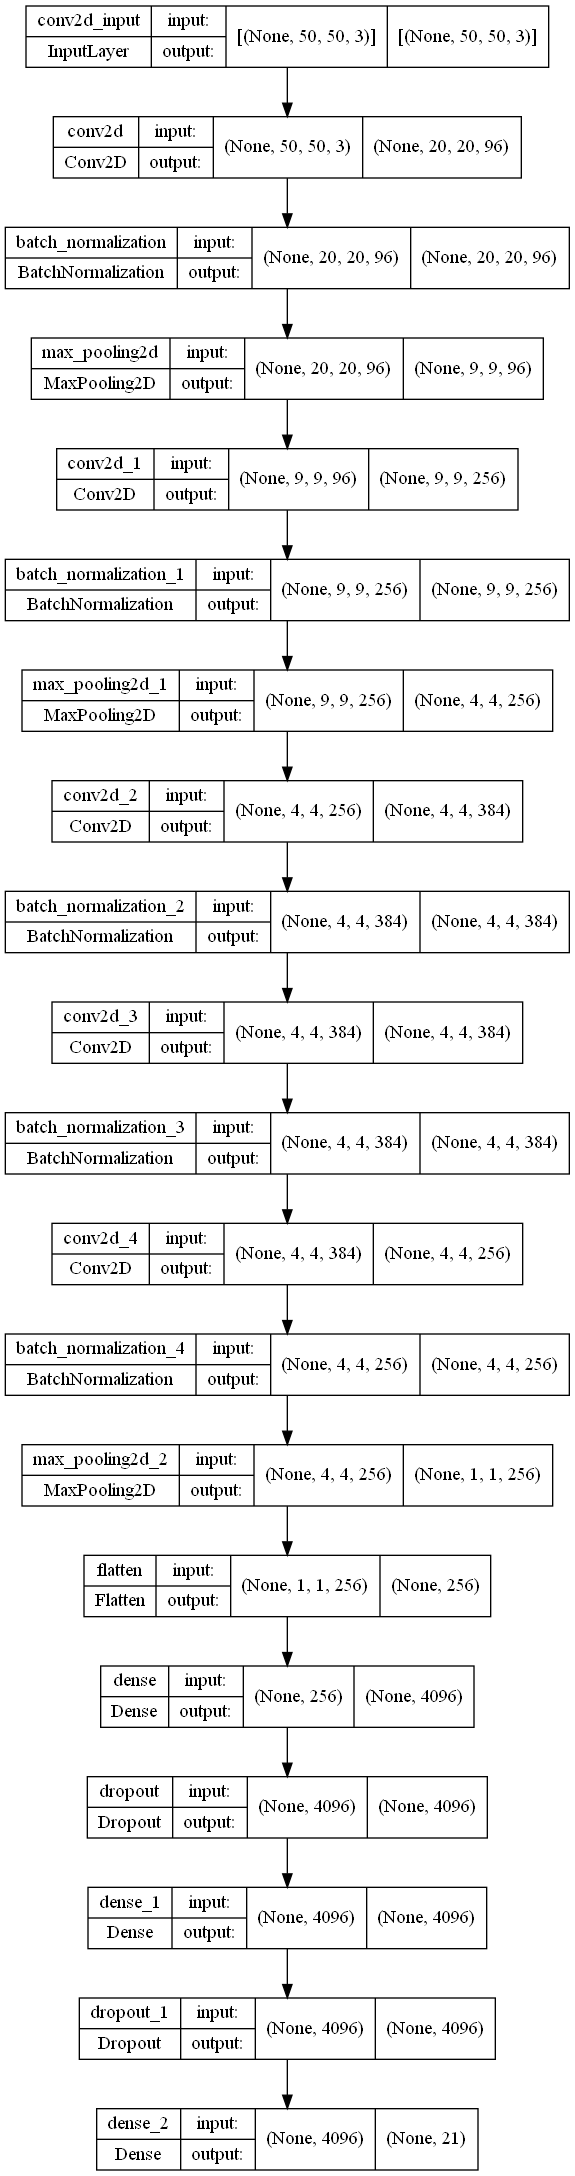

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn.png', show_shapes=True)

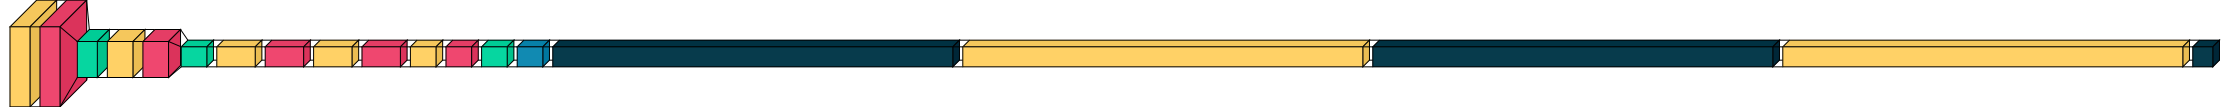

In [9]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='model.png').show() # write and show

visualkeras.layered_view(model)

In [117]:

# if os.path.exists(weights):
#     model1 = tf.keras.models.load_model(weights)
history = model.fit(train_generator,
                    epochs=10,
                    verbose=True,
                    validation_data=test_generator,
                    # steps_per_epoch= len(train_generator)//16,
                    # validation_steps= 1,
                    callbacks = callbacks )

Epoch 1/10
8025/8025 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8870
Epoch 1: val_loss did not improve from 0.05670
8025/8025 [==============================] - 433s 54ms/step - loss: 0.4247 - accuracy: 0.8870 - val_loss: 0.1083 - val_accuracy: 0.9649
Epoch 2/10
8024/8025 [============================>.] - ETA: 0s - loss: 0.2408 - accuracy: 0.9280
Epoch 2: val_loss did not improve from 0.05670
8025/8025 [==============================] - 367s 46ms/step - loss: 0.2408 - accuracy: 0.9280 - val_loss: 0.1043 - val_accuracy: 0.9647
Epoch 3/10
8025/8025 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9214
Epoch 3: val_loss did not improve from 0.05670
8025/8025 [==============================] - 339s 42ms/step - loss: 0.2618 - accuracy: 0.9214 - val_loss: 0.1099 - val_accuracy: 0.9630
Epoch 4/10
8024/8025 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.9207
Epoch 4: val_loss did not improve from 0.05670
8025/8025 [=

In [119]:
model.save("best.h5")

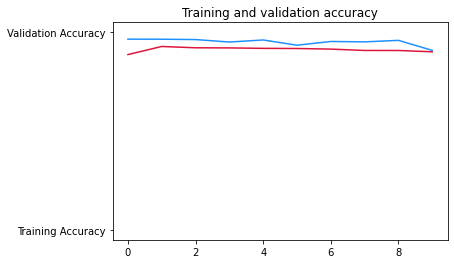

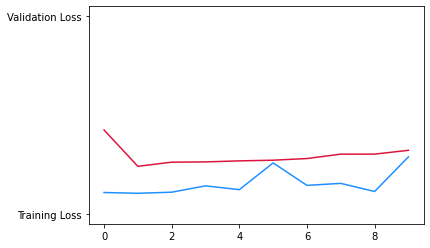

In [120]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'crimson', "Training Accuracy")
plt.plot(epochs, val_acc, 'dodgerblue', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'crimson', "Training Loss")
plt.plot(epochs, val_loss, 'dodgerblue', "Validation Loss")
plt.show()

In [121]:
#Evaluating the model
score = model.evaluate(train_generator)
print("\nTrain loss: ", score[0])
print("Train Accuracy: ", score[1])

8025/8025 [==============================] - 255s 32ms/step - loss: 0.3376 - accuracy: 0.9001

Train loss:  0.3375597298145294
Train Accuracy:  0.9000506401062012


In [122]:
#Evaluating the model
score_test = model.evaluate(validation_generator)
print("\nTest loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

502/502 [==============================] - 11s 23ms/step - loss: 0.2762 - accuracy: 0.9107

Test loss:  0.27621570229530334
Test Accuracy:  0.9106541872024536


In [125]:
#Evaluating the model
score_test = model.evaluate(test_generator)
print("\nTest loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

1505/1505 [==============================] - 17s 11ms/step - loss: 0.2885 - accuracy: 0.9082

Test loss:  0.2885096073150635
Test Accuracy:  0.9082242846488953


In [129]:
TEST_DATA_SET = VALIDATION_DATA_DIR
X,y = [],[]
for idx in CLASSES:
    path = os.path.join(TEST_DATA_SET, str(idx))
    for img in tqdm(os.listdir(path)):  
        full_path = os.path.join(path,img )
        img = tf.keras.preprocessing.image.load_img(full_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_tensor = tf.keras.preprocessing.image.img_to_array(img) 
        img_tensor /= 255. 
        X.append(img_tensor)
        y.append(CLASSES.index(idx))
        
        
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y)
X.shape, y.shape

100%|██████████| 750/750 [00:00<00:00, 2884.61it/s]


((16050, 50, 50, 3), (16050, 21))

In [130]:
print(model.evaluate(X,y))

502/502 [==============================] - 4s 9ms/step - loss: 0.2763 - accuracy: 0.9105
[0.2762609124183655, 0.910529613494873]


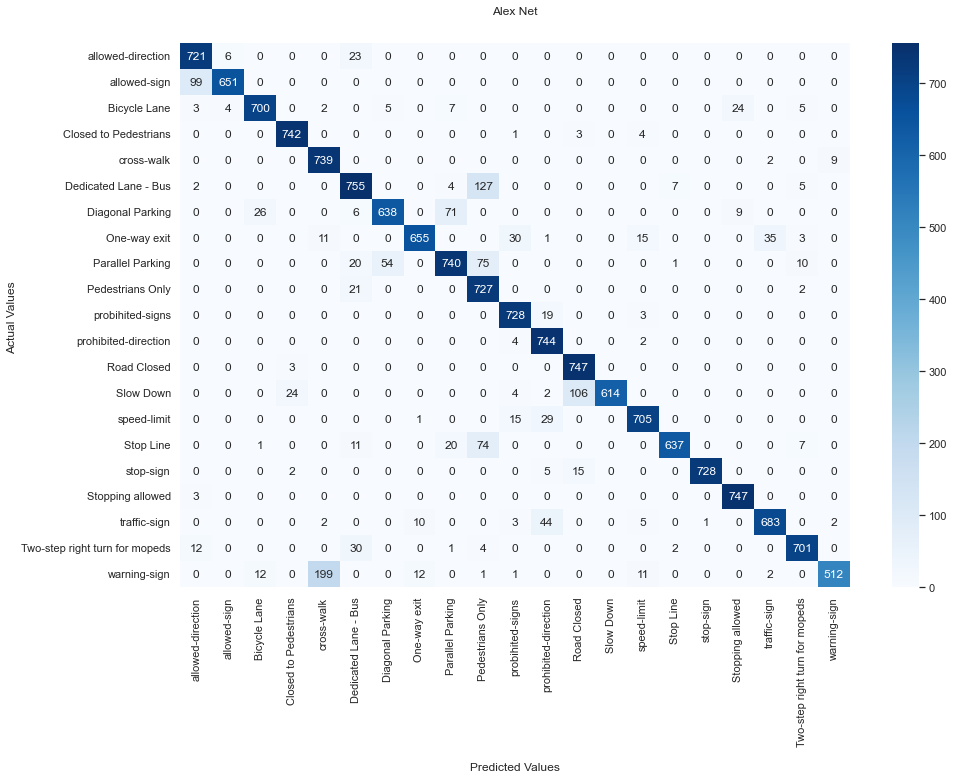

In [132]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

def conf_mat(y , model, title ):
    actual_y = [ np.argmax(i) for i in y]
    preds_y =  [ np.argmax(i) for i in model.predict(X)] 
    conf_mat = confusion_matrix(actual_y , preds_y)

    # sns.set( font_scale=1.5)
    plt.figure(figsize=(15,10))
    df_cm = pd.DataFrame(conf_mat, CLASSES,  CLASSES)
    sns.set(font_scale=1)
    ax = sns.heatmap(df_cm , annot=True, cmap='Blues', fmt='g')
    ax.set_ylabel('Actual Values ');
    ax.set_xlabel('\nPredicted Values')
    ax.set_title(f'{title}\n\n');
    # print(conf_mat)

conf_mat(y, model,'Alex Net' )

In [134]:
print('------------------- ALEXNET -------------------')
preds = model.predict(X)
print(classification_report(np.argmax(y, axis=1) , np.argmax(preds, axis=1) , target_names=CLASSES))

------------------- ALEXNET -------------------
                                precision    recall  f1-score   support

             allowed-direction       0.86      0.96      0.91       750
                  allowed-sign       0.98      0.87      0.92       750
                  Bicycle Lane       0.95      0.93      0.94       750
         Closed to Pedestrians       0.96      0.99      0.98       750
                    cross-walk       0.78      0.99      0.87       750
          Dedicated Lane - Bus       0.87      0.84      0.86       900
              Diagonal Parking       0.92      0.85      0.88       750
                  One-way exit       0.97      0.87      0.92       750
              Parallel Parking       0.88      0.82      0.85       900
              Pedestrians Only       0.72      0.97      0.83       750
              probihited-signs       0.93      0.97      0.95       750
          prohibited-direction       0.88      0.99      0.93       750
               

In [135]:
import itertools # outputs of CNN 
import matplotlib.pyplot as plt # viz 

import cv2 # import opencv - open images with python
import numpy as np # numpy - expand_dims 

import tensorflow as tf # Main dl architecture
from tensorflow.keras.models import load_model, Sequential # Modelling

In [138]:
v_model = load_model('best.h5')
# View the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 256)        1024      
 hNormalization)                                                 
                                                        

In [145]:
# This represents the TRAINED intermediate layers
intermediate_layers = [ i for i in model.layers  if 'conv' in i.name ]
intermediate_layers

In [146]:
# The intermediate model with TRAINED existing layers
intermediate_model = Sequential(intermediate_layers)

In [147]:
# The intermediate model is now represented as just the X layers that we took
intermediate_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 96)        34944     
                                                                 
 conv2d_1 (Conv2D)           multiple                  614656    
                                                                 
 conv2d_2 (Conv2D)           multiple                  885120    
                                                                 
 conv2d_3 (Conv2D)           multiple                  1327488   
                                                                 
 conv2d_4 (Conv2D)           multiple                  884992    
                                                                 
Total params: 3,747,200
Trainable params: 3,747,200
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Determine required input shape
intermediate_model.input_shape

(None, 50, 50, 3)

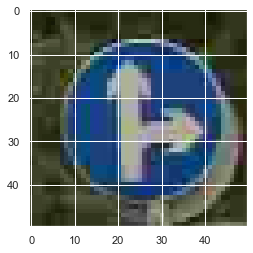

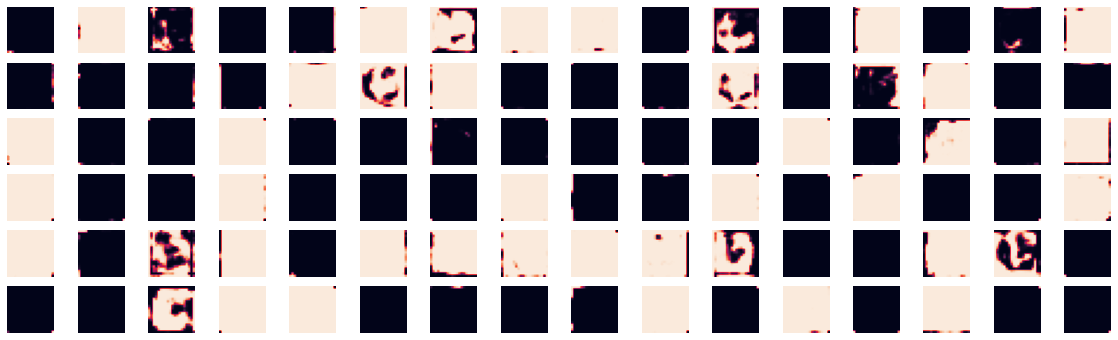

In [170]:

def view_conv(dir_name):
    # Load the image 
    image = cv2.imread(dir_name)
    resize = cv2.resize(image, (50,50))
    # Viz the resized Image
    plt.imshow(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))

    # Make a prediction 
    yhat = intermediate_model.predict(np.expand_dims(resize,0))

    # Viz Grid
    num_rows = 6
    num_cols = 16 

    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(20,6))
    for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
        ax[ax_idx[0], ax_idx[1]].imshow(yhat[0,:,:,idx])
        ax[ax_idx[0], ax_idx[1]].axis('off')



EXAMPLE_PIC = os.path.join(DATASET_DIR,'allowed-direction','020_0001.jpg')
view_conv(EXAMPLE_PIC)

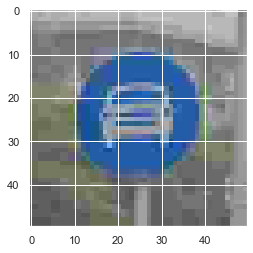

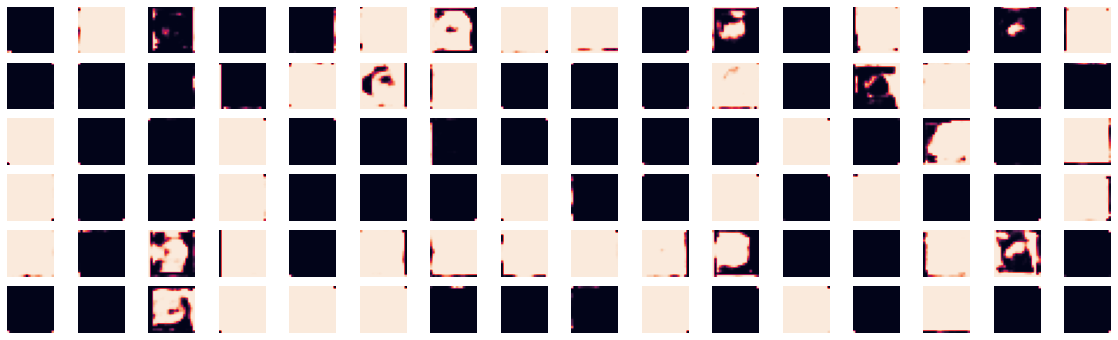

In [171]:
EXAMPLE_PIC = os.path.join(DATASET_DIR,'allowed-sign','028_1_0027.jpg')
view_conv(EXAMPLE_PIC)

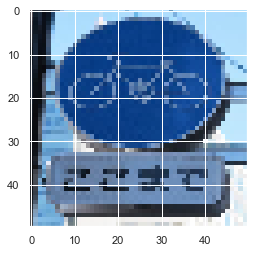

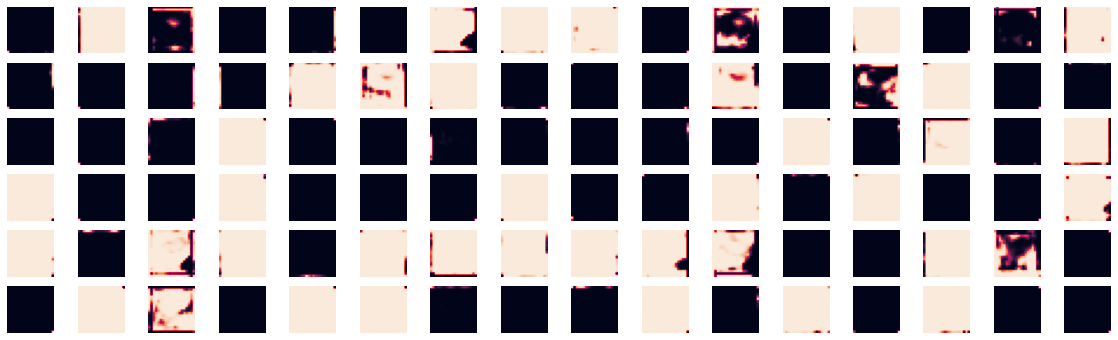

In [172]:
EXAMPLE_PIC = os.path.join(DATASET_DIR,'Bicycle Lane','Screenshot_1.jpg')
view_conv(EXAMPLE_PIC)